In [24]:
import math
import matplotlib.pyplot as plt
import numpy as np

states = np.array([0, 1, 2])
Transition = np.array([[0, 1/2, 1/2],
                       [1/2, 0, 1/2],
                       [1/2, 1/2, 0]])
obs = np.array([0, 0, 2, 1, 1, 2])
Observation = np.array([[1/2, 0, 1/3],
                        [1/2, 1/2, 1/3],
                        [0, 1/2, 1/3]])
Duration = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

In [25]:
def q_matrix(obs, Observation):
    return Observation[:, obs]

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i] for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

[[0.5        0.5        0.33333333 0.         0.         0.33333333]
 [0.5        0.5        0.33333333 0.5        0.5        0.33333333]
 [0.         0.         0.33333333 0.5        0.5        0.33333333]]


In [26]:
def matrix_mult_factor(log_alpha_row, Transition):
    alpha_row = np.exp(log_alpha_row)
    product = alpha_row @ Transition
    factor = np.sum(product)
    return np.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    if np.sum(np.exp(log_alpha_row)@Transition)!=0:
        return np.log(np.exp(log_alpha_row)@Transition/np.sum(np.exp(log_alpha_row)@Transition))
    else:
        return 0

[[0.16666667 0.         0.        ]
 [0.         0.08333333 0.        ]
 [0.01388889 0.01388889 0.        ]
 [0.         0.         0.        ]
 [0.         0.00173611 0.00347222]
 [0.00086806 0.         0.00115741]]


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/2903111836.py:10: RuntimeWarning: divide by zero encountered in log
  log_alpha[t] = np.log(start) + np.log(Duration[:, t]) + np.sum(np.log(q[:, :t+1]), axis=1)
/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/416927235.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.exp(log_alpha_row)@Transition/np.sum(np.exp(log_alpha_row)@Transition))
/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/2903111836.py:14: RuntimeWarning: divide by zero encountered in log
  log_alpha[t] = np.logaddexp(log_alpha[t], factor + vector + np.log(Duration[:, d]) + np.sum(np.log(q[:, t-d:t+1]), axis=1))
/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/2903111836.py:21: RuntimeWarning: divide by zero encountered in log
  log_alpha[t] = np.logaddexp(log_alpha[t], factor + vector + np.log(Duration[:, d]) + np.sum(np.log(q[:, t-d:t+1]), axis=1))
/var/folders/4g/4wgckcgj2zj9dw499ypxcw

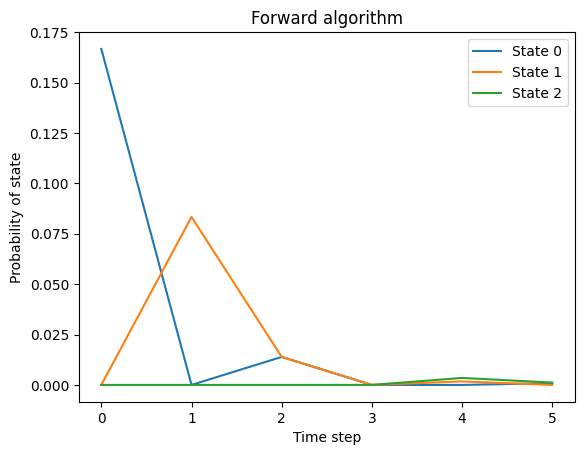

In [27]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_alpha = np.full((T, N), -np.inf)
    start = np.array([1/3, 1/3, 1/3])

    # initialization
    for t in range(D):
        log_alpha[t] = np.log(start) + np.log(Duration[:, t]) + np.sum(np.log(q[:, :t+1]), axis=1)
        for d in range(t):
            factor = np.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            log_alpha[t] = np.logaddexp(log_alpha[t], factor + vector + np.log(Duration[:, d]) + np.sum(np.log(q[:, t-d:t+1]), axis=1))
    
    # fill log_alpha[D:]
    for t in range(D, T):
        for d in range(D):
            factor = np.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            log_alpha[t] = np.logaddexp(log_alpha[t], factor + vector + np.log(Duration[:, d]) + np.sum(np.log(q[:, t-d:t+1]), axis=1))
    return np.exp(log_alpha)

fwd = forward(states, Transition, obs, q, Duration)
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

[[0.00347222 0.00173611 0.00520833]
 [0.00694444 0.01736111 0.01041667]
 [0.0625     0.04166667 0.02083333]
 [0.08333333 0.         0.08333333]
 [0.         0.16666667 0.16666667]
 [1.         1.         1.        ]]


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/842385874.py:14: RuntimeWarning: divide by zero encountered in log
  log_beta[t] = np.logaddexp(log_beta[t], np.logaddexp.reduce(np.row_stack([log_beta[t+d+1]]*N) + np.log(Transition) + np.log(np.row_stack([Duration[:, d]]*N)) + np.sum(np.log(q[:, t + 1:t + d + 2]), axis=1), axis=1))


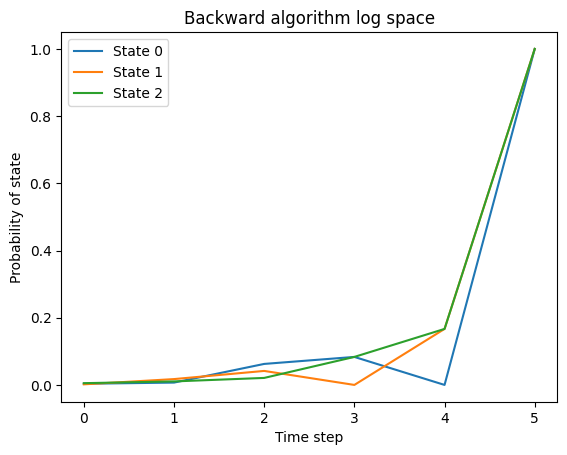

In [28]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_beta = np.full((T, N), -np.inf)

    # initialization, log_beta[-1]
    log_beta[-1] = np.zeros(N)
    
    # fill log_beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta[t] = np.logaddexp(log_beta[t], np.logaddexp.reduce(np.row_stack([log_beta[t+d+1]]*N) + np.log(Transition) + np.log(np.row_stack([Duration[:, d]]*N)) + np.sum(np.log(q[:, t + 1:t + d + 2]), axis=1), axis=1))

    return np.exp(log_beta)

bwd = backward(states, Transition, obs, q, Duration)
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/2903111836.py:10: RuntimeWarning: divide by zero encountered in log
  log_alpha[t] = np.log(start) + np.log(Duration[:, t]) + np.sum(np.log(q[:, :t+1]), axis=1)
/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/416927235.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(np.exp(log_alpha_row)@Transition/np.sum(np.exp(log_alpha_row)@Transition))
/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/2903111836.py:14: RuntimeWarning: divide by zero encountered in log
  log_alpha[t] = np.logaddexp(log_alpha[t], factor + vector + np.log(Duration[:, d]) + np.sum(np.log(q[:, t-d:t+1]), axis=1))
/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_1171/2903111836.py:21: RuntimeWarning: divide by zero encountered in log
  log_alpha[t] = np.logaddexp(log_alpha[t], factor + vector + np.log(Duration[:, d]) + np.sum(np.log(q[:, t-d:t+1]), axis=1))
/var/folders/4g/4wgckcgj2zj9dw499ypxcw

[[0.28571429 0.         0.        ]
 [0.         0.71428571 0.        ]
 [0.42857143 0.28571429 0.        ]
 [0.         0.         0.        ]
 [0.         0.14285714 0.28571429]
 [0.42857143 0.         0.57142857]]


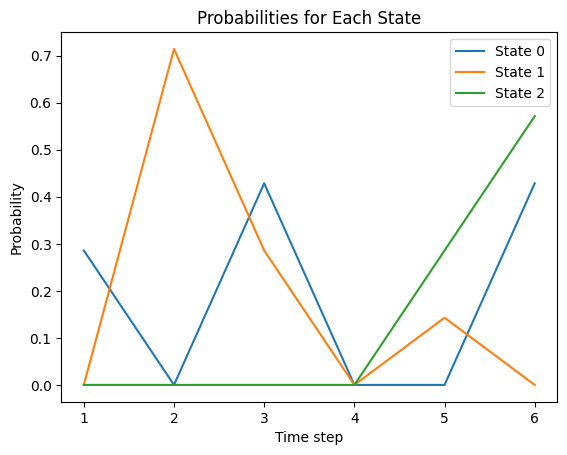

In [29]:
def fb_alg(states, Transition, obs, q, Duration):
    T = len(obs)
    alpha = forward(states, Transition, obs, q, Duration)
    beta = backward(states, Transition, obs, q, Duration)
    fb_probs = np.array(alpha) * np.array(beta) # log 
    
    # normalize
    fb_sum = np.sum(alpha[T-1])
    fb_probs /= fb_sum if fb_sum != 0 else 1
    return fb_probs

fb_probs = fb_alg(states, Transition, obs, q, Duration)
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), probs, label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()